# Perform seasonal and yearly trend decomposition of sea ice

## Data

### Locations for model development

A set of locations to develop the model(s) were provided by Eugene in `ak_ice_locs.csv`.

### CFSV2 experimental data

The data available to create the predictive models is derived from an "experimental" CFS V2 model with improved treatment of sea ice.

The data was provided in grib2 files in two formats: a 45-day forecast and "seasonal".

#### 45-day forecast

```
variables = {
    'ocn': {
        'temp': 'TMP_GDS0_SFC_ave6h',
        'salt': 'SALTY_GDS0_DBSL_ave6h',
        'ice_thk': 'ICETK_GDS0_SFC_ave6h',
    },
    'sic': {
        'ice_conc': 'ICE_C_GDS0_SFC_ave6h'
    },
    'sst': {
        'temp': 'POT_GDS0_DBSL_ave6h'
    }
}
```

#### Seasonal model

The seasonal model has a *ton* of variables and the time is weird, so I'm going to skip that for now.

## Methods

### 1. Build a LOESS model using only the 45-day model.

Attempt to build a model where input from `time=0` attempts to predict sea ice thickness and concentration 1 day, 1 week, and 1 month out.

In [1]:
from pathlib import Path

import geopandas as gdp
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL 

register_matplotlib_converters()

## 1. Load the locations

In [2]:
locs = pd.read_csv("ak_ice_locs.csv")

In [3]:
locs

,name,lon,lat
0,PAWIC,-160.05500,70.6870
1,PAWI10,-160.36500,70.7750
2,PAWI20,-160.72000,70.8800
3,PABRC,-156.87583,71.3128
4,PTBRC,-156.47000,71.4200
...,...,...,...
309,N56W175,-175.00000,56.0000
310,N55W165,-165.00000,55.0000
311,N55W167,-167.00000,55.0000
312,N55W169,-169.00000,55.0000


## 2. Identify the variables available

### 2a. 45 day forecasts

- ocn: TMP_GDS0_SFC_ave6h (temp), SALTY_GDS0_DBSL_ave6h (salt), ICETK_GDS0_SFC_ave6h (ice thickness)
- sic: ICE_C_GDS0_SFC_ave6h (ice concentration? cover?)
- sst: POT_GDS0_DBSL_ave6h (temp)

In [4]:
ocn_fname = '/data/assets/s2s/45day/ocn/2019/cfsm5.ocn.2019100100'
with xr.open_dataset(ocn_fname, engine='pynio') as ds:
    print(ds)

<xarray.Dataset>
Dimensions:                (g0_lat_1: 120, g0_lon_2: 720, initial_time0_hours: 180, lv_DBSL3: 11)
Coordinates:
  * initial_time0_hours    (initial_time0_hours) datetime64[ns] 2019-10-01T06...
  * lv_DBSL3               (lv_DBSL3) int32 5 15 25 35 45 55 65 75 85 95 105
  * g0_lat_1               (g0_lat_1) float32 89.75 89.25 88.75 ... 30.75 30.25
  * g0_lon_2               (g0_lon_2) float32 0.25 0.75 1.25 ... 359.2 359.8
Data variables:
    TMP_GDS0_SFC_ave6h     (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    SALTY_GDS0_DBSL_ave6h  (initial_time0_hours, lv_DBSL3, g0_lat_1, g0_lon_2) float32 ...
    ICETK_GDS0_SFC_ave6h   (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    OHC_GDS0_OLYR_ave6h    (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    initial_time0_encoded  (initial_time0_hours) float64 ...
    initial_time0          (initial_time0_hours) |S0 ...


In [5]:
sic_fname = '/data/assets/s2s/45day/sic/2019/iceCFSm5eCSISr1.sic.2019010100'
with xr.open_dataset(sic_fname, engine='pynio') as ds:
    print(ds)

<xarray.Dataset>
Dimensions:                (g0_lat_1: 120, g0_lon_2: 720, initial_time0_hours: 180)
Coordinates:
  * initial_time0_hours    (initial_time0_hours) datetime64[ns] 2019-01-01T06...
  * g0_lat_1               (g0_lat_1) float32 89.75 89.25 88.75 ... 30.75 30.25
  * g0_lon_2               (g0_lon_2) float32 0.25 0.75 1.25 ... 359.2 359.8
Data variables:
    ICE_C_GDS0_SFC_ave6h   (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    initial_time0_encoded  (initial_time0_hours) float64 ...
    initial_time0          (initial_time0_hours) |S0 ...


In [6]:
sst = '/data/assets/s2s/45day/sst/2019/iceCFSm5eCSISr1.sst.2019010100'
with xr.open_dataset(sst, engine='pynio') as ds:
    print(ds)

<xarray.Dataset>
Dimensions:                (g0_lat_1: 120, g0_lon_2: 720, initial_time0_hours: 180)
Coordinates:
  * initial_time0_hours    (initial_time0_hours) datetime64[ns] 2019-01-01T06...
  * g0_lat_1               (g0_lat_1) float32 89.75 89.25 88.75 ... 30.75 30.25
  * g0_lon_2               (g0_lon_2) float32 0.25 0.75 1.25 ... 359.2 359.8
Data variables:
    POT_GDS0_DBSL_ave6h    (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    initial_time0_encoded  (initial_time0_hours) float64 ...
    initial_time0          (initial_time0_hours) |S0 ...


In [7]:
variables = {
    'ocn': {
        'temp': 'TMP_GDS0_SFC_ave6h',
        'salt': 'SALTY_GDS0_DBSL_ave6h',
        'ice_thk': 'ICETK_GDS0_SFC_ave6h',
    },
    'sic': {
        'ice_conc': 'ICE_C_GDS0_SFC_ave6h'
    },
    'sst': {
        'temp': 'POT_GDS0_DBSL_ave6h'
    }
}

In [9]:
ocn_files = list(Path('/data/assets/s2s/45day/ocn/').glob('**/*ocn*'))
ocn_files.sort()
ocn_files = [str(f) + '.grb' for f in ocn_files]

sic_files = list(Path('/data/assets/s2s/45day/sic/').glob('**/*sic*'))
sic_files.sort()
sic_files = [str(f) + '.grb' for f in sic_files]

sst_files = list(Path('/data/assets/s2s/45day/sst/').glob('**/*sst*'))
sst_files.sort()
sst_files = [str(f) + '.grb' for f in sst_files]

print(len(ocn_files), len(sic_files), len(sst_files))

files = {
    'ocn': ocn_files,
    'sic': sic_files,
    'sst': sst_files
}

516 3347 3345


### 2b. "Seasonal" model description

In [10]:
!ls /data/assets/s2s/seasonal/iceCFSm5CSISr1_2007/iceCFSm5CSISr12007012100

flxf  ocnh  ocnhtime


In [11]:
!ls /data/assets/s2s/seasonal/iceCFSm5CSISr1_2007/iceCFSm5CSISr12007012100/flxf

flxf200701.grb	flxf200703.grb	flxf200705.grb	flxf200707.grb	flxf200709.grb
flxf200702.grb	flxf200704.grb	flxf200706.grb	flxf200708.grb	flxf200710.grb


In [12]:
flx_fname = '/data/assets/s2s/seasonal/iceCFSm5CSISr1_2007/iceCFSm5CSISr12007012100/flxf/flxf200701.grb'
ds = xr.open_dataset(flx_fname, engine='pynio')

In [13]:
# lots of variables
ds.close()

In [14]:
!ls -lhr '/data/assets/s2s/seasonal/iceCFSm5CSISr1_2007/iceCFSm5CSISr12007012100/ocnhtime/'


total 1.1G
-rw-r--r-- 1 1000 1000 117M Jan 19  2020 onhtime200710
-rw-r--r-- 1 1000 1000 113M Jan 19  2020 onhtime200709
-rw-r--r-- 1 1000 1000 116M Jan 19  2020 onhtime200708
-rw-r--r-- 1 1000 1000 116M Jan 19  2020 onhtime200707
-rw-r--r-- 1 1000 1000 113M Jan 19  2020 onhtime200706
-rw-r--r-- 1 1000 1000 118M Jan 19  2020 onhtime200705
-rw-r--r-- 1 1000 1000 115M Jan 19  2020 onhtime200704
-rw-r--r-- 1 1000 1000 119M Jan 19  2020 onhtime200703
-rw-r--r-- 1 1000 1000 107M Jan 18  2020 onhtime200702
-rw-r--r-- 1 1000 1000  42M Jan 18  2020 onhtime200701


In [15]:
# need to add grb
ocn_time = '/data/assets/s2s/seasonal/iceCFSm5CSISr1_2007/iceCFSm5CSISr12007012100/ocnhtime/onhtime200701.grb'
ds = xr.open_dataset(ocn_time, engine='pynio')

In [16]:
ds

<xarray.Dataset>
Dimensions:                (g0_lat_1: 120, g0_lon_2: 720, initial_time0_hours: 22, lv_DBSL3: 12)
Coordinates:
  * initial_time0_hours    (initial_time0_hours) datetime64[ns] 2007-01-21T12...
  * lv_DBSL3               (lv_DBSL3) int32 5 15 25 35 45 55 65 75 85 95 125 175
  * g0_lat_1               (g0_lat_1) float32 89.75 89.25 88.75 ... 30.75 30.25
  * g0_lon_2               (g0_lon_2) float32 0.25 0.75 1.25 ... 359.2 359.8
Data variables: (12/13)
    TMP_GDS0_SFC_ave6h     (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    POT_GDS0_DBSL_ave6h    (initial_time0_hours, lv_DBSL3, g0_lat_1, g0_lon_2) float32 ...
    SNO_D_GDS0_SFC_ave6h   (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    ICE_C_GDS0_SFC_ave6h   (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    ICETK_GDS0_SFC_ave6h   (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    U_ICE_GDS0_SFC_ave6h   (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    ...                     ...
    U_FLX_GDS0_SFC_ave6h   (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    V_FLX_GDS0_SFC_ave6h   (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    OHC_GDS0_OLYR_ave6h    (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    THFLX_GDS0_SFC_ave6h   (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    initial_time0_encoded  (initial_time0_hours) float64 ...
    initial_time0          (initial_time0_hours) |S0 ...

In [17]:
ocn_file = '/data/assets/s2s/seasonal/iceCFSm5CSISr1_2007/iceCFSm5CSISr12007012100/ocnh/ocnh200701.grb'
ds = xr.open_dataset(ocn_file, engine='pynio')

In [18]:
ds

<xarray.Dataset>
Dimensions:              (g0_lat_0: 120, g0_lon_1: 720, lv_DBSL2: 40)
Coordinates:
  * lv_DBSL2             (lv_DBSL2) int32 5 15 25 35 45 ... 3016 3483 3972 4478
  * g0_lat_0             (g0_lat_0) float32 89.75 89.25 88.75 ... 30.75 30.25
  * g0_lon_1             (g0_lon_1) float32 0.25 0.75 1.25 ... 358.8 359.2 359.8
Data variables: (12/39)
    TMP_GDS0_SFC_S51     (g0_lat_0, g0_lon_1) float32 ...
    POT_GDS0_DBSL_S51    (lv_DBSL2, g0_lat_0, g0_lon_1) float32 ...
    DZDT_GDS0_DBSL_S51   (lv_DBSL2, g0_lat_0, g0_lon_1) float32 ...
    UOGRD_GDS0_DBSL_S51  (lv_DBSL2, g0_lat_0, g0_lon_1) float32 ...
    VOGRD_GDS0_DBSL_S51  (lv_DBSL2, g0_lat_0, g0_lon_1) float32 ...
    SNO_D_GDS0_SFC_S51   (g0_lat_0, g0_lon_1) float32 ...
    ...                   ...
    DBSS_GDS0_OITL_S51   (g0_lat_0, g0_lon_1) float32 ...
    DBSS_GDS0_OBML_S51   (g0_lat_0, g0_lon_1) float32 ...
    DBSS_GDS0_OBIL_S51   (g0_lat_0, g0_lon_1) float32 ...
    OHC_GDS0_OLYR_S51    (g0_lat_0, g0_lon_1) float32 ...
    SSHG_GDS0_SFC_S51    (g0_lat_0, g0_lon_1) float32 ...
    THFLX_GDS0_SFC_S51   (g0_lat_0, g0_lon_1) float32 ...

In [19]:
ds.close()

## 2. Load a sample file and extract data at PAWIC

Method:
- function to load file, extract data at station, and return data and time of first slice
- distribute work to workers
- reduce will take data and time and concatenate into a new time-series stored in a dataarray
- the long time series will the be used for analysis

Details about dataset:
- First time step is at 6 hours of the date specified on the filename

In [20]:
#fpath = '../45day/sic/2012/iceCFSm5eCSISr1.sic.2012010100'
#fpath = '../45day/sst/2021/iceCFSm5eCSISr1.sst.2021010200'
# Cannot use open_mfopendataset() - no built-in Dask support for you

In [21]:
fpath = '../45day/sst/2021/iceCFSm5eCSISr1.sst.2021010200'
ds = xr.open_dataset(fpath, engine='pynio')
#print(ds.variables.keys())
#ds.close()

In [22]:
ds

<xarray.Dataset>
Dimensions:                (g0_lat_1: 120, g0_lon_2: 720, initial_time0_hours: 180)
Coordinates:
  * initial_time0_hours    (initial_time0_hours) datetime64[ns] 2021-01-02T06...
  * g0_lat_1               (g0_lat_1) float32 89.75 89.25 88.75 ... 30.75 30.25
  * g0_lon_2               (g0_lon_2) float32 0.25 0.75 1.25 ... 359.2 359.8
Data variables:
    POT_GDS0_DBSL_ave6h    (initial_time0_hours, g0_lat_1, g0_lon_2) float32 ...
    initial_time0_encoded  (initial_time0_hours) float64 ...
    initial_time0          (initial_time0_hours) |S0 ...

In [23]:
name, lon, lat = locs.iloc[0, :]
print(name, lon, lat)

PAWIC -160.055 70.687


In [24]:
pawic = ds.POT_GDS0_DBSL_ave6h.sel(dict(g0_lat_1=lat, g0_lon_2=lon), method='nearest')

In [25]:
pawic.nbytes

720

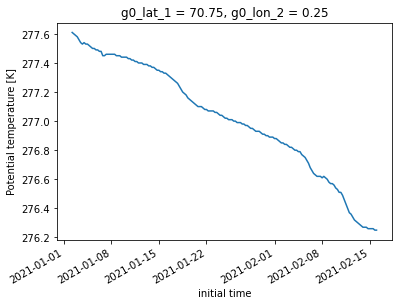

In [26]:
pawic.plot()

In [27]:
ds.close()

## 3. Figure out total size of all files and extracted data for a station

In [28]:
sea_ice_dir = Path('/data/assets/s2s/45day/sic/')
sea_ice_files = list(sea_ice_dir.glob('**/ice*'))
sea_ice_files.sort()
# need to add .grb
sea_ice_files = [str(f) + '.grb' for f in sea_ice_files]
nfiles = len(sea_ice_files)
station_size = nfiles * 720
print(f'{nfiles} sea ice files, total size for a station {station_size} bytes')

3349 sea ice files, total size for a station 2411280 bytes


In [29]:
sst_dir = Path('/data/assets/s2s/45day/sst/')
sst_files = list(sea_ice_dir.glob('**/ice*'))
sst_files.sort()
# need to add .grb
sst_files = [str(f) + '.grb' for f in sst_files]
nfiles = len(sst_files)
station_size = nfiles * 720
print(f'{nfiles} sst files, total size for a station {station_size} bytes')

3349 sst files, total size for a station 2411280 bytes


In [30]:
ocn_dir = Path('/data/assets/s2s/45day/ocn/')
ocn_files = list(ocn_dir.glob('**/cfsm5*'))
ocn_files.sort()
# need to add .grb
ocn_files = [str(f) + '.grb' for f in ocn_files]
nfiles = len(ocn_files)
station_size = nfiles * 720
print(f'{nfiles} sst files, total size for a station {station_size} bytes')

516 sst files, total size for a station 371520 bytes


In [31]:
print(f'{2411280/1024/1024:0.2f} MiB')

2.30 MiB


## 4. Gather data from a single varialbe at PAWIC in all files and aggregate into a single data container

Data to gather:
- "Best" time steps (the first output of the forecast) for all  45-day forecast

In [32]:
from dask.distributed import Client, progress

In [33]:
client = Client('estuaries01.ib.axiomptk:9000')

In [34]:
client

Client Scheduler: tcp://estuaries01.ib.axiomptk:9000 Dashboard: http://estuaries01.ib.axiomptk:9001/status,Cluster Workers: 8 Cores: 68 Memory: 188.73 GiB


In [35]:
### Function to extract data given station + filename
# POT_GDS0_DBSL_ave6h
# location = (lon, lat)

def get_station(fname, var, coords):
    lon, lat = coords
    with xr.open_dataset(fpath, engine='pynio') as ds:
        return ds[var].sel(dict(g0_lat_1=lat, g0_lon_2=lon), method='nearest').isel(initial_time0_hours=0)

In [36]:
# manually test things

def test_path(fpath, var, coords=(-160.055, 70.687)):
    print(fpath)
    #fpath = '/data/assets/s2s/45day/sst/2021/iceCFSm5eCSISr1.sst.2021010100.grb'
    #var = 'POT_GDS0_DBSL_ave6h'
    lon, lat = coords
    with xr.open_dataset(fpath, engine='pynio') as ds:
        return ds[var].sel(dict(g0_lat_1=lat, g0_lon_2=lon), method='nearest').isel(initial_time0_hours=0)

#### Anywhere from 100 to 250 ms to extract a time step

In [37]:
%%time
fpath = '/data/assets/s2s/45day/sst/2021/iceCFSm5eCSISr1.sst.2021011000.grb'
result = client.submit(test_path, fpath, 'POT_GDS0_DBSL_ave6h')
result.result()

CPU times: user 10.4 ms, sys: 5.85 ms, total: 16.2 ms
Wall time: 874 ms


<xarray.DataArray 'POT_GDS0_DBSL_ave6h' ()>
array(277.48999)
Coordinates:
    initial_time0_hours  datetime64[ns] 2021-01-10T06:00:00
    g0_lat_1             float32 70.75
    g0_lon_2             float32 0.25
Attributes:
    sub_center:               Environmental Modeling Center
    center:                   US National Weather Service - NCEP (WMC)
    long_name:                Potential temperature
    units:                    K
    level_indicator:          [160]
    gds_grid_type:            [0]
    parameter_table_version:  [2]
    parameter_number:         [13]
    model:                    Analysis from GDAS (Global Data Assimilation Sy...
    level:                    [5]
    forecast_time:            [1]
    forecast_time_units:      6 hours

In [46]:
def extract_station(fpath, var, coords):
    lon, lat = coords
    with xr.open_dataset(fpath, engine='pynio') as ds:
        return ds[var].sel(dict(g0_lat_1=lat, g0_lon_2=lon), method='nearest').isel(initial_time0_hours=0)

In [47]:
def station_wrapper(fname):
    var = 'POT_GDS0_DBSL_ave6h'
    lon, lat = -160.055, 70.687
    
    return extract_station(fname, var, (lon, lat))

In [48]:
# Test a file
result = client.submit(station_wrapper, fpath)
result.result()

<xarray.DataArray 'POT_GDS0_DBSL_ave6h' ()>
array(277.48999)
Coordinates:
    initial_time0_hours  datetime64[ns] 2021-01-10T06:00:00
    g0_lat_1             float32 70.75
    g0_lon_2             float32 0.25
Attributes:
    sub_center:               Environmental Modeling Center
    center:                   US National Weather Service - NCEP (WMC)
    long_name:                Potential temperature
    units:                    K
    level_indicator:          [160]
    gds_grid_type:            [0]
    parameter_table_version:  [2]
    parameter_number:         [13]
    model:                    Analysis from GDAS (Global Data Assimilation Sy...
    level:                    [5]
    forecast_time:            [1]
    forecast_time_units:      6 hours

In [50]:
def station_wrapper(fname):
    var = variables['sic']['ice_conc']
    lon, lat = -160.055, 70.687
    
    return extract_station(fname, var, (lon, lat))

futures = client.map(station_wrapper, sic_files)
results = client.gather(iter(futures))
results = list(results)
sic_ds = xr.concat(results, dim='initial_time0_hours')
sic_ds.plot()

NIOError: Unable to open file

In [ ]:
%%time
def station_wrapper(fname):
    var = variables['ocn']['temp']
    lon, lat = -160.055, 70.687
    
    return extract_station(fname, var, (lon, lat))

futures = client.map(station_wrapper, ocn_files)
results = client.gather(iter(futures))
results = list(results)
ocn_ds = xr.concat(results, dim='initial_time0_hours')
ocn_ds.plot()

In [387]:
ds.close()